A written summary of this notebook can be found here:
<a href="https://docs.google.com/document/d/1ixcw77YqVwDlHVwd8yMmWrxTdTnFWGL1kgmeqkeDoHg/edit?usp=sharing">
    Google Doc </a>


# Downloading the necessary packages and data

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
main_df=pd.read_pickle('Data/data_from_imdb_extra_2.pkl')

# Splitting the test and training data

In [6]:
#A helper function that drops all movies of a given year from a dataframe
def drop_test(df,L):
    '''input a dataframe of movies (df) and a list of years as int (L)
    outputs a dataframe that does not include the movies released in the years in L'''
    indices =[]
    for i in range(len(df)):
        if df.iloc[i]['year'] in L:
            indices.append(i)
    new_df=df.drop(indices)
    return(new_df)

We decided to disregard 2020 and 2021 since we make the assumption that trends in film will return to their pre-pandemic norms.  This means that we reserve 2018 and 2019 as our testing years.

In [8]:
train_set=drop_test(main_df, [2018,2019,2020,2021])

We write a function that performs a Time Series Split for our specific type of data.  Since we have a different number of movies released each year, the TimeSeriesSplit function included in scikitlearn would not have worked for our project.

In [9]:
def timeseries_split2(df, k, n):
    '''takes in a movie dataframe (df),  k (int)
    and outputs a tuple that behaves like kfold.split when kfold =kfold = TimeSeriesSplit(n_splits = k,
                           test_size = 1)
    but only keeps n years in each train_set
    that is, the output is a tuple of 2-tuples, where
    the first element of each tuple is the indices of the train set (each train set contains n years of movies) and
    the second element is the indices of the test set (one year of movies)
    unlike TimeSeriesSplit it can only handle one dataframe at a time'''
    if len(df['year'].value_counts()) <k+n:
        raise ValueError("Not enough data for given k and n")
        
    df=df.copy()
    
    answer=[]
    i=0
    while i <k:
        last_year=df['year'].max()
        
        #get array of indices of last year in list
        index_set=np.array(df[df['year']==last_year].index)
        
        #delete rows from dataframe
        df=drop_test(df,[last_year])
        
        m=1
        temp_train=[]
        while m<n+1:
            temp_train=list(df[df['year'] == last_year-m].index) + temp_train
            m=m+1
        
        #add to train_sets
        index_set2=np.array(temp_train)
        
        new_set=(index_set2, index_set)
        answer=[new_set] + answer
        
        i=i+1
    
    return tuple(answer)

While performing cross validations, the train-test split was:

Train 1: 2001-2012\
Test 1: 2013

Train 2: 2002-2013\
Test 2: 2014

Train 3: 2003-2014\
Test 3: 2015

Train 4: 2004-2015\
Test 4: 2016

Train 5: 2005-2016\
Test 5: 2017

# The Main Model

We write a function that finds precisions and recalls for our model.

The model is a voting model that incorporates a random forest, a K-neighbors classifier, a support vector classifier, and a logistic regression.  The options on the models and the weights in the voting model were determined by cross validations performed in previous notebooks.

In [30]:
def voting(df, columns):
    '''takes in a list of features (columns) and applies the voting model to those features in the dataframe (df)
    Creates an array of precisions (0) and recalls (1), which can then be processed
    Uses a 5-fold validation split'''
    n=1
    precs=np.zeros((n,5))
    recs = np.zeros((n,5))
    for i in range(0,n):
        x=0
        for train_index, val_index in timeseries_split2(df,5,12):

            # make voting model 
            voting = VotingClassifier([
                ('forest',RandomForestClassifier(max_depth=10, n_estimators=80)),
                ('knn', KNeighborsClassifier(n_neighbors=1, p=1)),
                ('svc', SVC(C=2**(-1*9), kernel='poly', degree=10, max_iter=100000)),
                ('log_reg', LogisticRegression(C=2**(-1*5), max_iter=1000))
                                    ],
                weights=[1,1,2,2])
            voting.fit(
                df.iloc[train_index][columns],
                df.iloc[train_index]['is_nominee']
                    )
            pred=voting.predict(df.iloc[val_index][columns]
                        )

            # add metrics to the tables
            precs[i,x]=precision_score(df.iloc[val_index]['is_nominee'], pred, zero_division=0)
            recs[i,x]=recall_score(df.iloc[val_index]['is_nominee'], pred, zero_division=0)
            x=x+1

    return(precs, recs)

Next, we calculate the precisions and recalls for the 5 validation sets.

In [31]:
viable_columns=['United States', 'Family', 'Adventure', 'Comedy', 'Fantasy', 'Other',
       'G', 'PG', 'PG-13', 'R', 'Unrated', 'metascore_available', 'prev_dir',
       'prev_prod', 'metascore_0', 'metascore_ave', 'month', 'prev_pc']

In [32]:
metrics_voting=voting(train_set, viable_columns)

In [33]:
metrics_voting

(array([[1.        , 0.75      , 0.66666667, 0.83333333, 1.        ]]),
 array([[0.5       , 0.6       , 0.66666667, 1.        , 0.4       ]]))

The average precision and recall over the validation sets are given below.

In [34]:
print('Precision:')
print(np.mean(metrics_voting[0]))
print('Recall:')
print(np.mean(metrics_voting[1]))

Precision:
0.85
Recall:
0.6333333333333333


Let's finally check our work on the test set that we set aside.

In [35]:
metrics_final=voting(main_df, viable_columns)
metrics_final

(array([[1.        , 1.        , 1.        , 0.66666667, 0.75      ]]),
 array([[0.4       , 0.8       , 0.16666667, 0.5       , 0.6       ]]))

The above 5 columns correspond to 2017 (a validation set), 2018, 2019 (the test sets), 2020, and 2021 (years affected by the pandemic).

Let's see this on a graph.

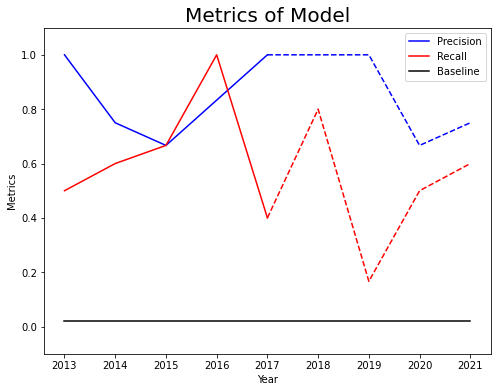

In [51]:
plt.figure(figsize=(8,6))

val_years=[str(i) for i in range(2013,2018)]
test_years=[str(i) for i in range(2017,2022)]

plt.plot(val_years, metrics_voting[0].reshape(-1,1), label='Precision', color='blue')
plt.plot(val_years, metrics_voting[1].reshape(-1,1), label='Recall', color='r')

plt.plot(test_years, metrics_final[0].reshape(-1,1), '--', color='blue')
plt.plot(test_years, metrics_final[1].reshape(-1,1), '--', color='r')

plt.plot(['2013','2021'], [0.02, 0.02], label='Baseline', color='k')

plt.title('Metrics of Model', fontsize=20)
plt.legend()

plt.xlabel('Year')
plt.ylabel('Metrics')

plt.ylim(-0.1,1.1)
plt.show()

There's quite a bit of variance, but we stay safely above the baseline (what you would expect if you randomly guess nominees)

# Exploring the features

Which features are the most important when determining the model?  When we exclude one feature at a time, we obtain the following:

In [53]:
all_precs=[]
all_recs=[]
for feature in viable_columns:
    #print(feature)
    new_cols=viable_columns.copy()
    new_cols.remove(feature)
    metrics=voting(train_set, new_cols)
    all_precs.append(metrics[0])
    all_recs.append(metrics[1])

C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

In [56]:
for i in range(len(all_precs)):
    print(viable_columns[i])
    print(np.mean(all_precs[i]))

United States
0.7761904761904762
Family
0.86
Adventure
0.8666666666666668
Comedy
0.8666666666666668
Fantasy
0.8666666666666668
Other
0.85
G
0.8261904761904763
PG
0.825
PG-13
0.8666666666666668
R
0.8666666666666668
Unrated
0.8428571428571429
metascore_available
0.85
prev_dir
0.8666666666666668
prev_prod
0.8666666666666668
metascore_0
0.825
metascore_ave
0.7295238095238095
month
0.8666666666666668
prev_pc
0.8666666666666668


In [57]:
for i in range(len(all_recs)):
    print(viable_columns[i])
    print(np.mean(all_recs[i]))

United States
0.7
Family
0.6933333333333332
Adventure
0.7
Comedy
0.7
Fantasy
0.7
Other
0.6333333333333333
G
0.6
PG
0.6666666666666667
PG-13
0.7
R
0.7
Unrated
0.7
metascore_available
0.6333333333333333
prev_dir
0.7
prev_prod
0.7
metascore_0
0.5933333333333334
metascore_ave
0.6
month
0.7333333333333333
prev_pc
0.7


So the most important indicators are metascore, followed by rating, but really it seems that all the features are working together about evenly.

Now let's explore if we exclude one category at a time, instead of just one feature.

In [58]:
viable_columns

['United States',
 'Family',
 'Adventure',
 'Comedy',
 'Fantasy',
 'Other',
 'G',
 'PG',
 'PG-13',
 'R',
 'Unrated',
 'metascore_available',
 'prev_dir',
 'prev_prod',
 'metascore_0',
 'metascore_ave',
 'month',
 'prev_pc']

In [60]:
features_by_type=[
['Family','Adventure','Comedy','Fantasy','Other','G','PG','PG-13','R',
 'Unrated','metascore_available','prev_dir','prev_prod','metascore_0','metascore_ave','month','prev_pc'],
['United States','G','PG','PG-13','R','Unrated',
 'metascore_available','prev_dir','prev_prod','metascore_0','metascore_ave','month','prev_pc'],
['United States','Family','Adventure','Comedy','Fantasy','Other',
 'metascore_available','prev_dir','prev_prod','metascore_0','metascore_ave','month','prev_pc'],
['United States','Family','Adventure','Comedy','Fantasy','Other','G','PG','PG-13','R','Unrated',
 'prev_dir','prev_prod','month','prev_pc'],
['United States','Family','Adventure','Comedy','Fantasy','Other','G','PG','PG-13','R','Unrated',
 'metascore_available','metascore_0','metascore_ave','month'],
['United States','Family','Adventure','Comedy','Fantasy','Other','G','PG','PG-13','R','Unrated',
 'metascore_available','prev_dir','prev_prod','metascore_0','metascore_ave','prev_pc']
]

feature_type_names=['US', 'genre', 'certificates', 'metascore', 'previous success', 'month']

In [61]:
all_precs=[]
all_recs=[]
for L in features_by_type:    
    metrics=voting(train_set, L)
    all_precs.append(metrics[0])
    all_recs.append(metrics[1])

C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [62]:
for i in range(len(features_by_type)):
    print(feature_type_names[i])
    print(np.mean(all_precs[i]))

US
0.7761904761904762
genre
0.86
certificates
0.825
metascore
0.6
previous success
0.8333333333333333
month
0.85


In [63]:
for i in range(len(features_by_type)):
    print(feature_type_names[i])
    print(np.mean(all_recs[i]))

US
0.7
genre
0.66
certificates
0.6666666666666667
metascore
0.16
previous success
0.4866666666666667
month
0.6666666666666666
